In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df=pd.read_csv('data/diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## data cleaning

In [31]:
df.shape

(53940, 11)

In [32]:
df.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

**Rows**: 53940
**Columns**: 11
**Target**: price

**Goal:** Build a regression model that predicts the price of a diamond based on its physical attributes and quality indicators

In [33]:
print(df['cut'].value_counts())
print(df['clarity'].value_counts())
print(df['color'].value_counts())


cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64


In [34]:
df.duplicated().sum()

np.int64(0)

In [35]:
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

drop the unnecessary columns 

In [36]:
df2=df.drop('Unnamed: 0',axis=1)
df2.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


splitting the target from the features

In [37]:
y=df2['price']
x=df2.drop('price',axis=1)

**handling outliers of numerical features**

checking the distribution 

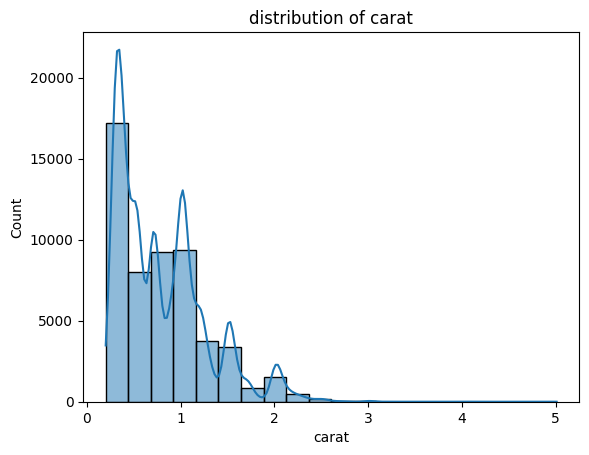

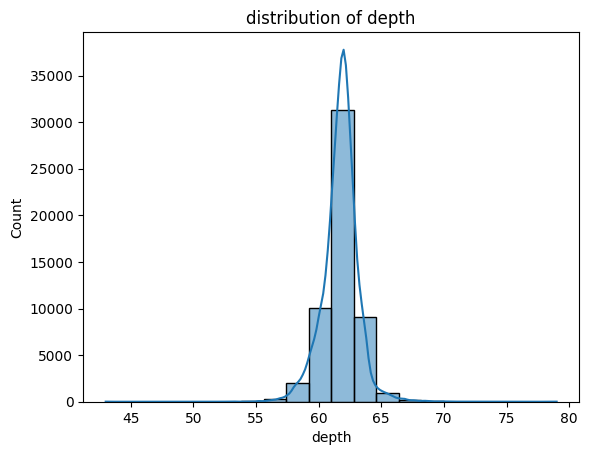

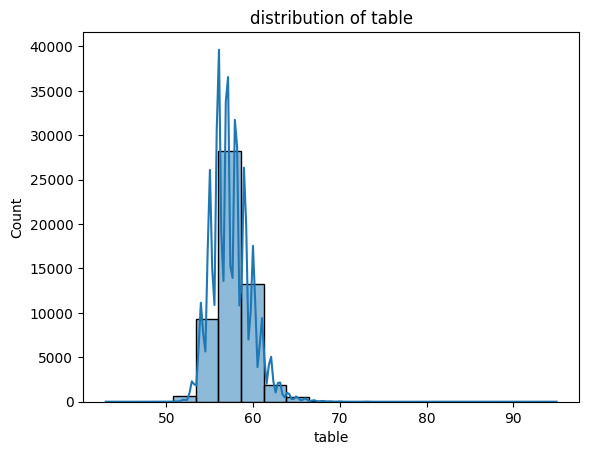

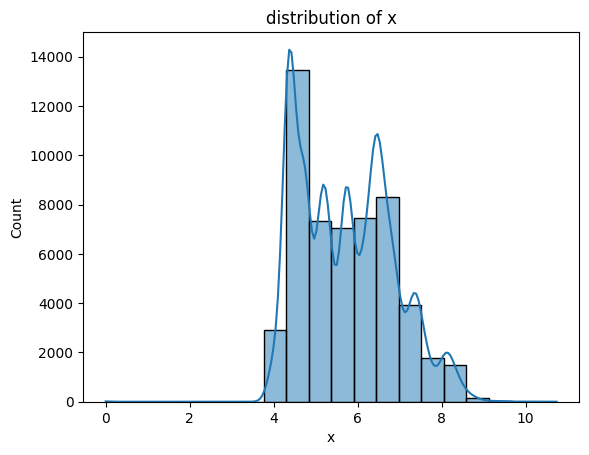

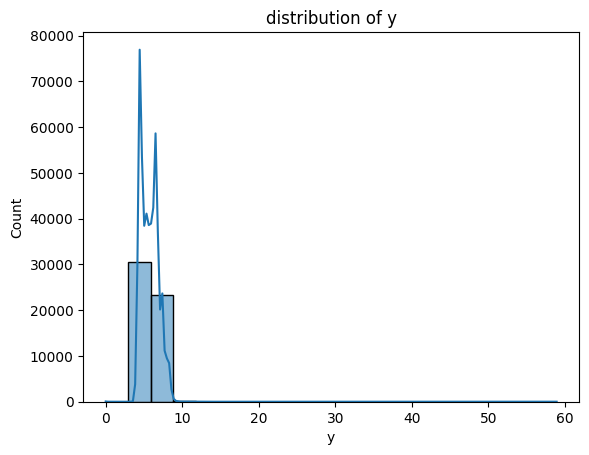

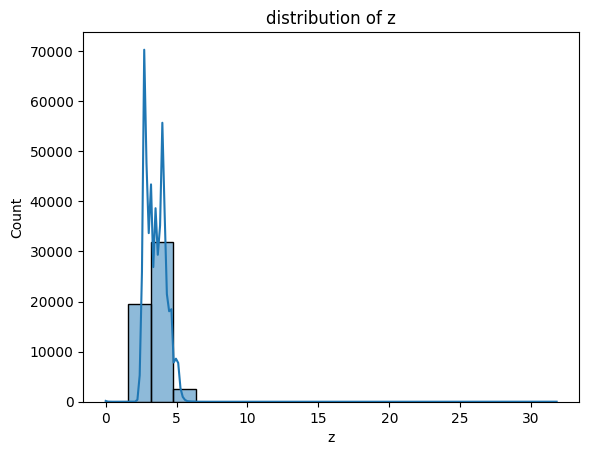

In [38]:
numeric_features=['carat','depth','table','x','y','z']
for feature in numeric_features:
    sns.histplot(x[feature],kde=True,bins=20)
    plt.title(f'distribution of {feature}')
    plt.show()

In [39]:
from scipy.stats import normaltest,boxcox

In [40]:
for feature in numeric_features:
    stat,p=normaltest(x[feature])
    print(f'{feature}--->{p:.4f}')

carat--->0.0000
depth--->0.0000
table--->0.0000
x--->0.0000
y--->0.0000
z--->0.0000


In [41]:
for feature in numeric_features:
    min_val=x[feature].min()
    if min_val<=0:
        x_shifted=x[feature]-min_val+1
    else:
        x_shifted=x[feature]
    transformed,lam=boxcox(x_shifted)
    stat,p=normaltest(transformed)
    print(f'{feature}--->{p:.4f}')

carat--->0.0000
depth--->0.0000
table--->0.0000
x--->0.0000
y--->0.0000
z--->0.0000


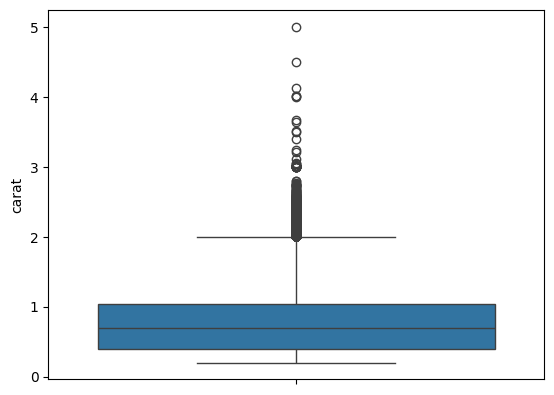

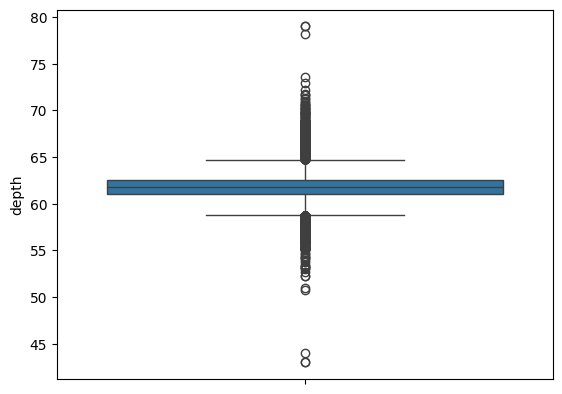

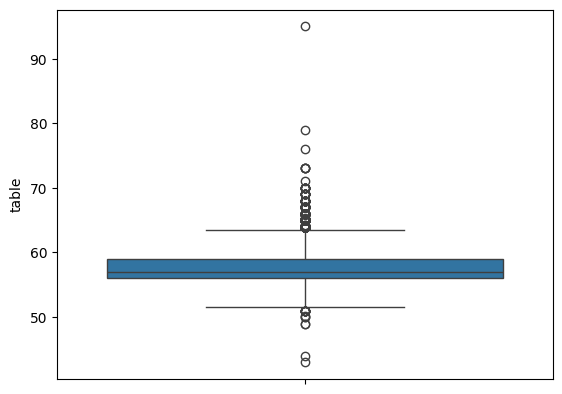

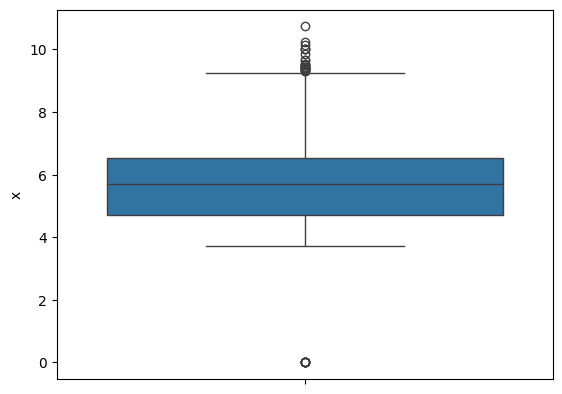

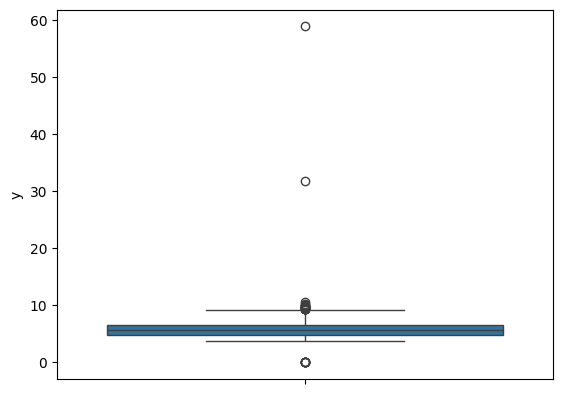

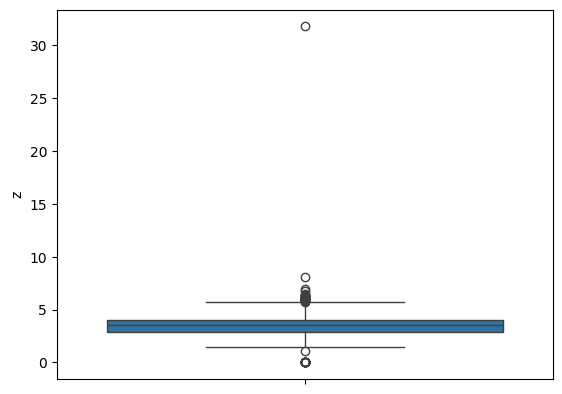

In [42]:
for feature in numeric_features:
    sns.boxplot(x[feature])
    plt.show()

since the features are skewed we will use the interquartile method to remove the outliers

In [43]:
x_cleaned=x.copy()
for feature in numeric_features:
    Q1=x[feature].quantile(0.25)
    Q3=x[feature].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    x_cleaned=x_cleaned[(x_cleaned[feature]>=lower_bound)&(x_cleaned[feature]<=upper_bound)]
x_cleaned=pd.DataFrame(x_cleaned)
x_cleaned

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


**encoding the categorical features for correlation matrix step**

In [44]:
from sklearn.preprocessing import OrdinalEncoder

In [45]:
x_encoded=x_cleaned
encoder=OrdinalEncoder(categories=[['Fair','Good','Very Good','Premium','Ideal']])
x_encoded['cut']=encoder.fit_transform(x_encoded[['cut']]).flatten()
x_encoded

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,4.0,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,3.0,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.29,3.0,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,1.0,J,SI2,63.3,58.0,4.34,4.35,2.75
5,0.24,2.0,J,VVS2,62.8,57.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...
53935,0.72,4.0,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,1.0,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,2.0,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,3.0,H,SI2,61.0,58.0,6.15,6.12,3.74


In [46]:
x_encoded=pd.get_dummies(x_encoded,columns=['color','clarity'],drop_first=True)
x_encoded=x_encoded.astype(float)
x_encoded

,carat,cut,depth,table,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,4.0,61.5,55.0,3.95,3.98,2.43,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,3.0,59.8,61.0,3.89,3.84,2.31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3.0,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,1.0,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.24,2.0,62.8,57.0,3.94,3.96,2.48,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4.0,60.8,57.0,5.75,5.76,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,0.72,1.0,63.1,55.0,5.69,5.75,3.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,0.70,2.0,62.8,60.0,5.66,5.68,3.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,0.86,3.0,61.0,58.0,6.15,6.12,3.74,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


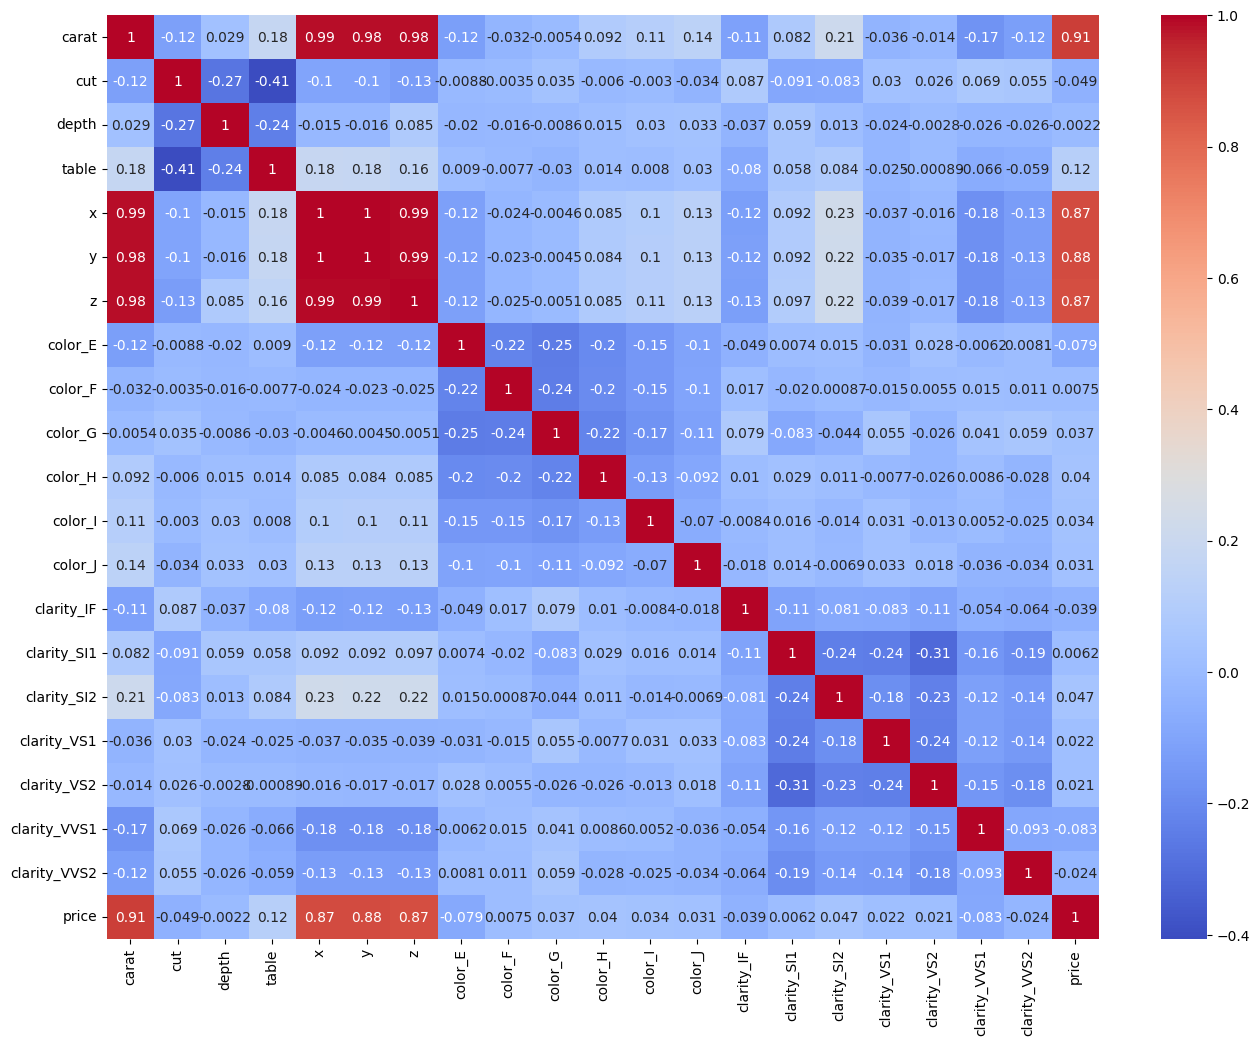

In [47]:
plt.figure(figsize=(16,12))
dataf=pd.merge(x_encoded,y,how='inner',left_index=True,right_index=True)
correlation_matrix = dataf.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


drop high correlated features if using plain linear regression
in our case we will let ridge and lasso handle it

In [48]:
dataf=dataf.reset_index(drop=True)
x=dataf.iloc[:,:-1]
y=dataf.iloc[:,-1]

## model building

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [51]:
y_train_original=y_train.copy()
transformed,lam2=boxcox(y_train)
y_train=pd.Series(transformed)

In [52]:
model_no_reg = make_pipeline(StandardScaler(), LinearRegression())
model_no_reg.fit(x_train, y_train)

model_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))  
model_ridge.fit(x_train, y_train)

model_lasso = make_pipeline(StandardScaler(), Lasso(alpha=1.0))
model_lasso.fit(x_train, y_train)

model_elastic = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5))  
model_elastic.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

## model evaluation 

In [53]:
from scipy.special import inv_boxcox


In [54]:
x

,carat,cut,depth,table,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,4.0,61.5,55.0,3.95,3.98,2.43,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,3.0,59.8,61.0,3.89,3.84,2.31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.29,3.0,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.31,1.0,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.24,2.0,62.8,57.0,3.94,3.96,2.48,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49299,0.72,4.0,60.8,57.0,5.75,5.76,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49300,0.72,1.0,63.1,55.0,5.69,5.75,3.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49301,0.70,2.0,62.8,60.0,5.66,5.68,3.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49302,0.86,3.0,61.0,58.0,6.15,6.12,3.74,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
model_coefs = {
    "No Regularization": model_no_reg.named_steps['linearregression'].coef_,
    "Ridge (L2)": model_ridge.named_steps['ridge'].coef_,
    "Lasso (L1)": model_lasso.named_steps['lasso'].coef_,
    "Elastic Net (L1+L2)": model_elastic.named_steps['elasticnet'].coef_,
}

df_coefs = pd.DataFrame(model_coefs, index=[f"Feature {i+1}" for i in range(x.shape[1])])
df_coefs

,No Regularization,Ridge (L2),Lasso (L1),Elastic Net (L1+L2)
Feature 1,-0.300184,-0.299485,0.0,0.000000
Feature 2,0.012698,0.012733,-0.0,-0.000000
Feature 3,0.032863,0.032481,0.0,0.000000
Feature 4,0.012664,0.012680,0.0,0.000000
Feature 5,0.568766,0.562883,0.0,0.004679
Feature 6,0.201330,0.202876,0.0,0.004829
Feature 7,0.092064,0.095695,0.0,0.001479
Feature 8,-0.012026,-0.012020,-0.0,-0.000000
Feature 9,-0.020851,-0.020842,0.0,0.000000
Feature 10,-0.037755,-0.037744,0.0,0.000000


In [60]:
features=x.columns
for model_name,coefs in model_coefs.items():
    zero_features=[features[i] for i,coef in enumerate(coefs) if coef==0]
    print(f'{model_name} canceled features: {zero_features}')

No Regularization canceled features: []
Ridge (L2) canceled features: []
Lasso (L1) canceled features: ['carat', 'cut', 'depth', 'table', 'x', 'y', 'z', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
Elastic Net (L1+L2) canceled features: ['carat', 'cut', 'depth', 'table', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


In [28]:
results = []
models = {
    "No Regularization": model_no_reg,
    "Ridge (L2)": model_ridge,
    "Lasso (L1)": model_lasso,
    "Elastic Net (L1+L2)": model_elastic,
}

for name, model in models.items():
    y_train_pred_bc = model.predict(x_train)
    y_test_pred_bc = model.predict(x_test)
    y_train_pred=inv_boxcox(y_train_pred_bc,lam2)
    y_test_pred=inv_boxcox(y_test_pred_bc,lam2)
    train_mse = mean_squared_error(y_train_original, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    results.append({
        "Model": name,
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train R²": r2_score(y_train_original, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
    })

df_results = pd.DataFrame(results)
df_results

,Model,Train MSE,Test MSE,Train R²,Test R²
0,No Regularization,4.616697e+05,4.756283e+05,0.960865,0.959250
1,Ridge (L2),4.610385e+05,4.749962e+05,0.960918,0.959304
2,Lasso (L1),1.368210e+07,1.356589e+07,-0.159813,-0.162266
3,Elastic Net (L1+L2),1.342307e+07,1.331040e+07,-0.137856,-0.140378


plain linear regression or ridge regression are the best to use in this case but **linear regression can't be used because we didn't handle the multicolinearity** so ridge regression is the best option 